# Model Explainability with LIME

This notebook provides explainability for the Welli ML models using LIME (Local Interpretable Model-agnostic Explanations).

**What you'll find here:**
- **Individual prediction explanations** for both clustering and churn models
- **Feature importance analysis** at the instance level
- **Model behavior understanding** for different user types
- **Trust and transparency** in model decisions

**Requirements:**
- Trained models from `user_clustering.ipynb` and `churn_model.ipynb`
- Training dataset from `data_creation.ipynb`

LIME helps answer: *"Why did the model make this specific prediction for this user?"*

In [1]:
# Install LIME if not already installed
try:
    import lime
    print("✅ LIME already installed")
except ImportError:
    print("📦 Installing LIME...")
    !pip install lime
    import lime
    print("✅ LIME installed successfully")

📦 Installing LIME...
  Using cached lime-0.2.0.1.tar.gz (275 kB)
  Using cached lime-0.2.0.1.tar.gz (275 kB)
  Preparing metadata (setup.py) ...   Preparing metadata (setup.py) ... -done
done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 1.8 MB/s eta 0:00:002.0 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 1.8 MB/s eta 0:00:002.0 MB/s eta 0:00:01
     ╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/13.2 MB 6.9 MB/s eta 0:00:02  Downloading scikit_image-0.25.2-cp310-cp310-macosx_12_0_arm64.whl (13.2 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 13.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 13.0 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/22.4 MB ? eta -:--:--Collecting scipy (from lime)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4 MB 12.8 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.4/22.4

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import os
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Ready to explain model predictions...")

Libraries imported successfully!
Ready to explain model predictions...


In [10]:
# Load the training dataset and models
data_path = "../data/training_dataset.csv"
models_dir = {
    "clustering": "../ml_models/clustering/",
    "churn": "../ml_models/churn_classification/"
}

# Check if required files exist
required_files = [
    "training_dataset.csv",
    "kmeans_model.joblib", 
    "clustering_scaler.joblib",
    "cluster_info.json",
    "churn_model.joblib",
    "churn_scaler.joblib"
]

# Load models
kmeans_model = joblib.load(os.path.join(models_dir["clustering"], "kmeans_model.joblib"))
clustering_scaler = joblib.load(os.path.join(models_dir["clustering"], "clustering_scaler.joblib"))
churn_model = joblib.load(os.path.join(models_dir["churn"], "churn_model.joblib"))
churn_scaler = joblib.load(os.path.join(models_dir["churn"], "churn_scaler.joblib"))

with open(os.path.join(models_dir["clustering"], "cluster_info.json"), 'r') as f:
    cluster_info = json.load(f)
    # Load the training dataset
df = pd.read_csv(data_path)
print(f"📂 Training dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print("🤖 All models loaded successfully!")

📂 Training dataset loaded: 2000 rows, 14 columns
🤖 All models loaded successfully!


In [11]:
# Define feature sets (exactly as used in the models)
clustering_features = [
    'session_count',
    'avg_session_duration', 
    'streak_length',
    'preferred_time_of_day',
    'content_engagement_rate',
    'notification_response_rate'
]

churn_features = [
    "days_since_signup",
    "total_sessions", 
    "avg_session_duration",
    "streak_length",
    "last_login_days_ago",
    "content_completion_rate",
    "notification_response_rate",
    "goal_progress_percentage"
]

print("📋 Feature sets defined:")
print(f"   • Clustering features: {len(clustering_features)}")
print(f"   • Churn features: {len(churn_features)}")

# Prepare feature matrices
X_clustering = df[clustering_features].values
X_churn = df[churn_features].values

print(f"\n📐 Feature matrices prepared:")
print(f"   • Clustering: {X_clustering.shape}")
print(f"   • Churn: {X_churn.shape}")

📋 Feature sets defined:
   • Clustering features: 6
   • Churn features: 8

📐 Feature matrices prepared:
   • Clustering: (2000, 6)
   • Churn: (2000, 8)


In [12]:
# Create wrapper functions for LIME (LIME expects probability outputs)
def clustering_predict_proba(X):
    """
    Wrapper for clustering model to return probabilities for LIME
    Since KMeans doesn't have predict_proba, we'll use distances to clusters
    """
    X_scaled = clustering_scaler.transform(X)
    distances = kmeans_model.transform(X_scaled)
    
    # Convert distances to probabilities (closer = higher probability)
    # Use negative distances and apply softmax
    neg_distances = -distances
    exp_distances = np.exp(neg_distances - np.max(neg_distances, axis=1, keepdims=True))
    probabilities = exp_distances / np.sum(exp_distances, axis=1, keepdims=True)
    
    return probabilities

def churn_predict_proba(X):
    """
    Wrapper for churn model to return probabilities for LIME
    """
    X_scaled = churn_scaler.transform(X)
    return churn_model.predict_proba(X_scaled)

print("🔧 Model wrapper functions created for LIME compatibility")

# Test the wrapper functions
test_sample_clustering = X_clustering[:1]
test_sample_churn = X_churn[:1]

clustering_probs = clustering_predict_proba(test_sample_clustering)
churn_probs = churn_predict_proba(test_sample_churn)

print(f"\n✅ Wrapper functions tested:")
print(f"   • Clustering probabilities shape: {clustering_probs.shape}")
print(f"   • Churn probabilities shape: {churn_probs.shape}")

🔧 Model wrapper functions created for LIME compatibility

✅ Wrapper functions tested:
   • Clustering probabilities shape: (1, 3)
   • Churn probabilities shape: (1, 2)


In [13]:
# Create LIME explainers
print("🔍 Creating LIME explainers...")

# Clustering explainer
clustering_explainer = LimeTabularExplainer(
    X_clustering,
    feature_names=clustering_features,
    class_names=[f"Cluster {i}: {cluster_info['clusters'][str(i)]['name']}" 
                 for i in range(len(cluster_info['clusters']))],
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

# Churn explainer
churn_explainer = LimeTabularExplainer(
    X_churn,
    feature_names=churn_features,
    class_names=['Active User', 'Churned User'],
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

print("✅ LIME explainers created successfully!")
print(f"   • Clustering explainer: {len(cluster_info['clusters'])} clusters")
print(f"   • Churn explainer: 2 classes (Active/Churned)")

🔍 Creating LIME explainers...
✅ LIME explainers created successfully!
   • Clustering explainer: 3 clusters
   • Churn explainer: 2 classes (Active/Churned)


In [14]:
# Select sample users for explanation
print("👥 Selecting sample users for explanation...")

# Select diverse users for explanation
sample_indices = []

# One user from each type
for user_type in df['user_type'].unique():
    user_subset = df[df['user_type'] == user_type]
    sample_indices.append(user_subset.index[0])  # First user of each type

# Add some random users
np.random.seed(42)
additional_samples = np.random.choice(df.index, size=3, replace=False)
sample_indices.extend(additional_samples)

# Remove duplicates
sample_indices = list(set(sample_indices))

print(f"📝 Selected {len(sample_indices)} users for explanation:")
for i, idx in enumerate(sample_indices):
    user_type = df.loc[idx, 'user_type']
    churn_status = 'Churned' if df.loc[idx, 'churn'] == 1 else 'Active'
    print(f"   {i+1}. User {idx}: {user_type} user, {churn_status}")

# Display sample user details
sample_users = df.loc[sample_indices]
print("\n📊 Sample user characteristics:")
display(sample_users[['user_type', 'churn'] + clustering_features + churn_features].head())

👥 Selecting sample users for explanation...
📝 Selected 6 users for explanation:
   1. User 0: active user, Active
   2. User 353: active user, Active
   3. User 1860: low_engagement user, Active
   4. User 1333: moderate user, Churned
   5. User 1400: low_engagement user, Active
   6. User 700: moderate user, Active

📊 Sample user characteristics:


,user_type,churn,session_count,avg_session_duration,streak_length,preferred_time_of_day,content_engagement_rate,notification_response_rate,days_since_signup,total_sessions,avg_session_duration,streak_length,last_login_days_ago,content_completion_rate,notification_response_rate,goal_progress_percentage
0,active,0,21,17.558516,19,2,0.872892,0.738740,151,39,17.558516,19,2,0.714521,0.738740,90.316165
353,active,0,22,8.798331,21,2,0.909020,0.763618,36,37,8.798331,21,0,0.944047,0.763618,83.920882
1860,low_engagement,0,4,4.221895,1,2,0.133485,0.138607,85,9,4.221895,1,4,0.460668,0.138607,17.171797
1333,moderate,1,12,11.108740,2,0,0.699927,0.413392,46,31,11.108740,2,1,0.512402,0.413392,32.620479
1400,low_engagement,0,4,5.672591,1,1,0.077941,0.044502,52,8,5.672591,1,4,0.248065,0.044502,33.647762


In [15]:
# Function to explain clustering predictions
def explain_clustering_prediction(user_index, show_plot=True):
    """
    Explain why a user was assigned to a specific cluster
    """
    user_data = X_clustering[user_index]
    user_info = df.loc[user_index]
    
    # Get actual prediction
    probabilities = clustering_predict_proba(user_data.reshape(1, -1))[0]
    predicted_cluster = np.argmax(probabilities)
    cluster_name = cluster_info['clusters'][str(predicted_cluster)]['name']
    
    print(f"\n🎯 CLUSTERING EXPLANATION - User {user_index}")
    print(f"User Type: {user_info['user_type']}")
    print(f"Predicted Cluster: {predicted_cluster} - {cluster_name}")
    print(f"Confidence: {probabilities[predicted_cluster]:.3f}")
    
    # Generate LIME explanation
    explanation = clustering_explainer.explain_instance(
        user_data, 
        clustering_predict_proba,
        num_features=len(clustering_features),
        top_labels=len(cluster_info['clusters'])
    )
    
    if show_plot:
        # Show explanation plot
        fig = explanation.as_pyplot_figure(label=predicted_cluster)
        plt.title(f'Clustering Explanation - User {user_index}\n'
                 f'Predicted: Cluster {predicted_cluster} - {cluster_name}')
        plt.tight_layout()
        plt.show()
    
    # Return explanation data
    return explanation, predicted_cluster, probabilities

# Function to explain churn predictions
def explain_churn_prediction(user_index, show_plot=True):
    """
    Explain why a user was predicted to churn or stay
    """
    user_data = X_churn[user_index]
    user_info = df.loc[user_index]
    
    # Get actual prediction
    probabilities = churn_predict_proba(user_data.reshape(1, -1))[0]
    churn_probability = probabilities[1]
    predicted_churn = int(churn_probability >= 0.5)
    actual_churn = user_info['churn']
    
    # Determine risk level
    if churn_probability >= 0.7:
        risk_level = "High"
    elif churn_probability >= 0.4:
        risk_level = "Medium"
    else:
        risk_level = "Low"
    
    print(f"\n🎯 CHURN EXPLANATION - User {user_index}")
    print(f"User Type: {user_info['user_type']}")
    print(f"Actual Status: {'Churned' if actual_churn else 'Active'}")
    print(f"Predicted Status: {'Churned' if predicted_churn else 'Active'}")
    print(f"Churn Probability: {churn_probability:.3f}")
    print(f"Risk Level: {risk_level}")
    
    # Generate LIME explanation
    explanation = churn_explainer.explain_instance(
        user_data, 
        churn_predict_proba,
        num_features=len(churn_features)
    )
    
    if show_plot:
        # Show explanation plot
        fig = explanation.as_pyplot_figure(label=1)  # Explain churn class
        plt.title(f'Churn Explanation - User {user_index}\n'
                 f'Churn Probability: {churn_probability:.3f} ({risk_level} Risk)')
        plt.tight_layout()
        plt.show()
    
    # Return explanation data
    return explanation, churn_probability, probabilities

print("🔧 Explanation functions defined and ready to use!")

🔧 Explanation functions defined and ready to use!


🔍 CLUSTERING EXPLANATIONS

🎯 CLUSTERING EXPLANATION - User 0
User Type: active
Predicted Cluster: 1 - Routine Builders
Confidence: 0.888


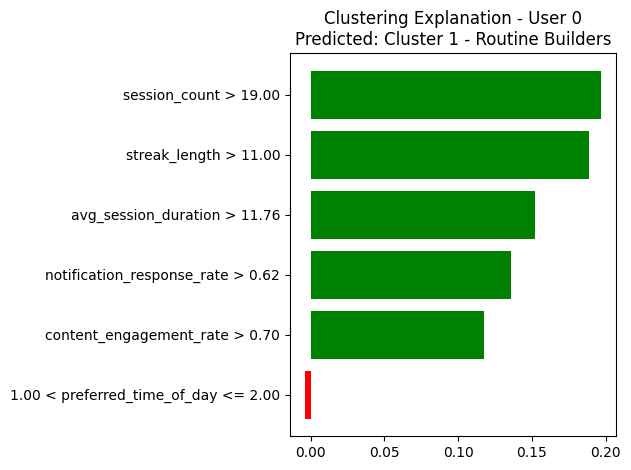


------------------------------

🎯 CLUSTERING EXPLANATION - User 353
User Type: active
Predicted Cluster: 1 - Routine Builders
Confidence: 0.823


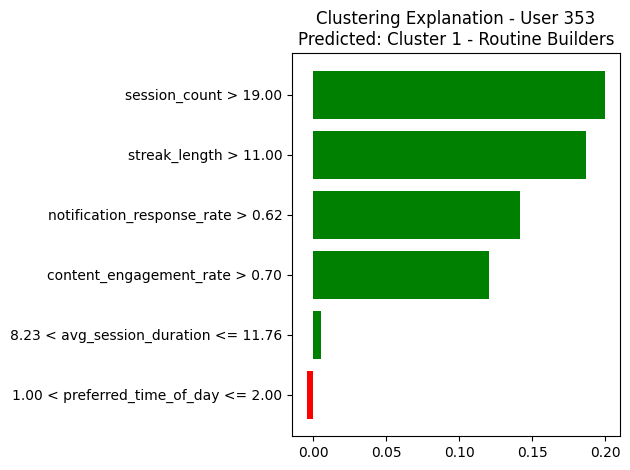


------------------------------

🎯 CLUSTERING EXPLANATION - User 1860
User Type: low_engagement
Predicted Cluster: 0 - Casual Check-ins
Confidence: 0.751


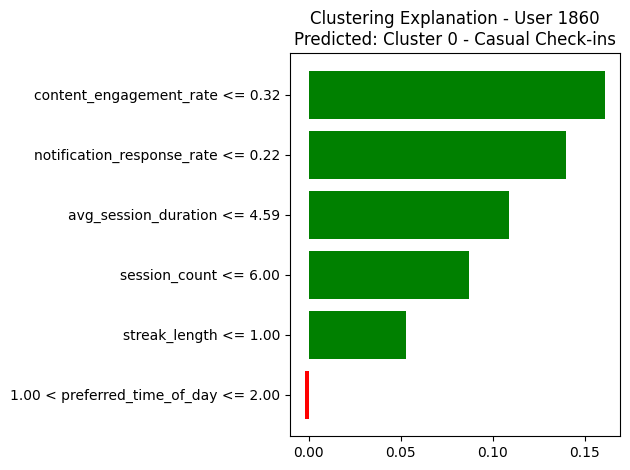


------------------------------


In [16]:
# Explain clustering for sample users
print("🔍 CLUSTERING EXPLANATIONS")
print("=" * 50)

clustering_explanations = {}

for i, user_idx in enumerate(sample_indices[:3]):  # Show first 3 users
    explanation, predicted_cluster, probabilities = explain_clustering_prediction(user_idx)
    clustering_explanations[user_idx] = {
        'explanation': explanation,
        'predicted_cluster': predicted_cluster,
        'probabilities': probabilities
    }
    
    if i < len(sample_indices) - 1:
        print("\n" + "-" * 30)

🚨 CHURN PREDICTION EXPLANATIONS

🎯 CHURN EXPLANATION - User 0
User Type: active
Actual Status: Active
Predicted Status: Active
Churn Probability: 0.052
Risk Level: Low


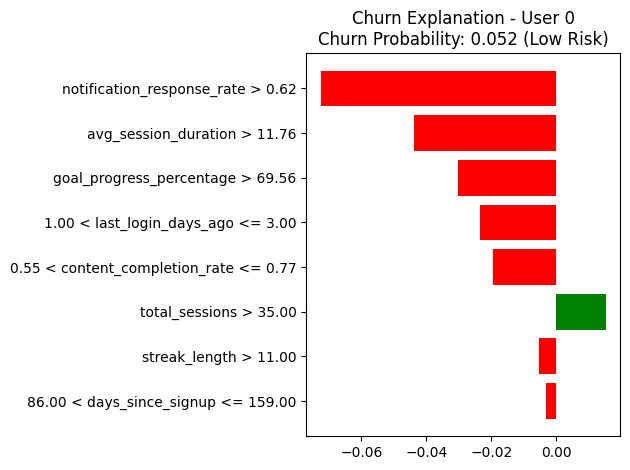


------------------------------

🎯 CHURN EXPLANATION - User 353
User Type: active
Actual Status: Active
Predicted Status: Active
Churn Probability: 0.162
Risk Level: Low


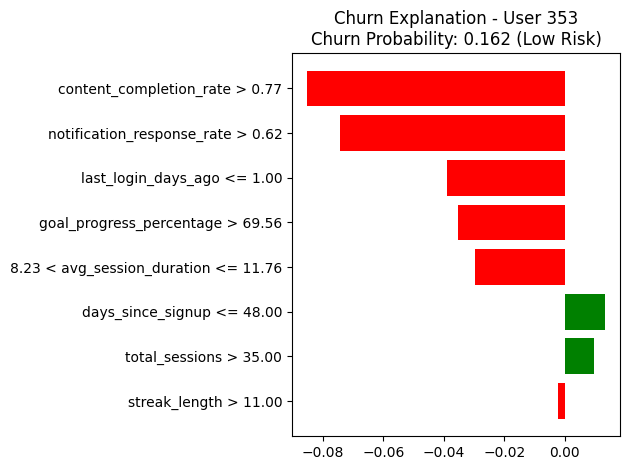


------------------------------

🎯 CHURN EXPLANATION - User 1860
User Type: low_engagement
Actual Status: Active
Predicted Status: Churned
Churn Probability: 0.628
Risk Level: Medium


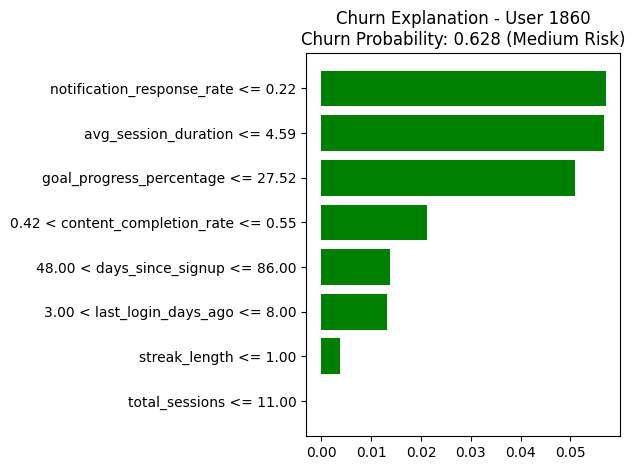


------------------------------


In [17]:
# Explain churn predictions for sample users
print("🚨 CHURN PREDICTION EXPLANATIONS")
print("=" * 50)

churn_explanations = {}

for i, user_idx in enumerate(sample_indices[:3]):  # Show first 3 users
    explanation, churn_prob, probabilities = explain_churn_prediction(user_idx)
    churn_explanations[user_idx] = {
        'explanation': explanation,
        'churn_probability': churn_prob,
        'probabilities': probabilities
    }
    
    if i < len(sample_indices) - 1:
        print("\n" + "-" * 30)

In [18]:
# Analyze feature importance across explanations
def analyze_feature_importance_patterns():
    """
    Analyze common patterns in feature importance across different explanations
    """
    print("📈 FEATURE IMPORTANCE ANALYSIS")
    print("=" * 50)
    
    # Analyze clustering feature importance
    clustering_feature_importance = {feature: [] for feature in clustering_features}
    
    for user_idx in sample_indices:
        explanation, _, _ = explain_clustering_prediction(user_idx, show_plot=False)
        
        # Get feature importance for the predicted class
        predicted_cluster = clustering_explanations.get(user_idx, {}).get('predicted_cluster', 0)
        feature_importance = explanation.as_list(label=predicted_cluster)
        
        for feature, importance in feature_importance:
            # Clean feature name (remove value information)
            clean_feature = feature.split(' ')[0] if ' ' in feature else feature
            if clean_feature in clustering_feature_importance:
                clustering_feature_importance[clean_feature].append(abs(importance))
    
    # Calculate average importance
    clustering_avg_importance = {}
    for feature, importances in clustering_feature_importance.items():
        if importances:
            clustering_avg_importance[feature] = np.mean(importances)
    
    # Analyze churn feature importance  
    churn_feature_importance = {feature: [] for feature in churn_features}
    
    for user_idx in sample_indices:
        explanation, _, _ = explain_churn_prediction(user_idx, show_plot=False)
        
        # Get feature importance for churn class (label=1)
        feature_importance = explanation.as_list(label=1)
        
        for feature, importance in feature_importance:
            # Clean feature name
            clean_feature = feature.split(' ')[0] if ' ' in feature else feature
            if clean_feature in churn_feature_importance:
                churn_feature_importance[clean_feature].append(abs(importance))
    
    # Calculate average importance
    churn_avg_importance = {}
    for feature, importances in churn_feature_importance.items():
        if importances:
            churn_avg_importance[feature] = np.mean(importances)
    
    return clustering_avg_importance, churn_avg_importance

# Run the analysis
clustering_importance, churn_importance = analyze_feature_importance_patterns()

# Display results
print("\n🏷️  Most Important Features for Clustering:")
sorted_clustering = sorted(clustering_importance.items(), key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(sorted_clustering[:5], 1):
    print(f"   {i}. {feature}: {importance:.3f}")

print("\n🚨 Most Important Features for Churn Prediction:")
sorted_churn = sorted(churn_importance.items(), key=lambda x: x[1], reverse=True)
for i, (feature, importance) in enumerate(sorted_churn[:5], 1):
    print(f"   {i}. {feature}: {importance:.3f}")

📈 FEATURE IMPORTANCE ANALYSIS

🎯 CLUSTERING EXPLANATION - User 0
User Type: active
Predicted Cluster: 1 - Routine Builders
Confidence: 0.888

🎯 CLUSTERING EXPLANATION - User 353
User Type: active
Predicted Cluster: 1 - Routine Builders
Confidence: 0.823

🎯 CLUSTERING EXPLANATION - User 1860
User Type: low_engagement
Predicted Cluster: 0 - Casual Check-ins
Confidence: 0.751

🎯 CLUSTERING EXPLANATION - User 1333
User Type: moderate
Predicted Cluster: 2 - Explorers
Confidence: 0.641

🎯 CLUSTERING EXPLANATION - User 1400
User Type: low_engagement
Predicted Cluster: 0 - Casual Check-ins
Confidence: 0.821

🎯 CLUSTERING EXPLANATION - User 700
User Type: moderate
Predicted Cluster: 2 - Explorers
Confidence: 0.646

🎯 CLUSTERING EXPLANATION - User 1333
User Type: moderate
Predicted Cluster: 2 - Explorers
Confidence: 0.641

🎯 CLUSTERING EXPLANATION - User 1400
User Type: low_engagement
Predicted Cluster: 0 - Casual Check-ins
Confidence: 0.821

🎯 CLUSTERING EXPLANATION - User 700
User Type: modera

🎛️  Creating comprehensive explanation dashboard...

🎯 CLUSTERING EXPLANATION - User 0
User Type: active
Predicted Cluster: 1 - Routine Builders
Confidence: 0.888

🎯 CHURN EXPLANATION - User 0
User Type: active
Actual Status: Active
Predicted Status: Active
Churn Probability: 0.052
Risk Level: Low


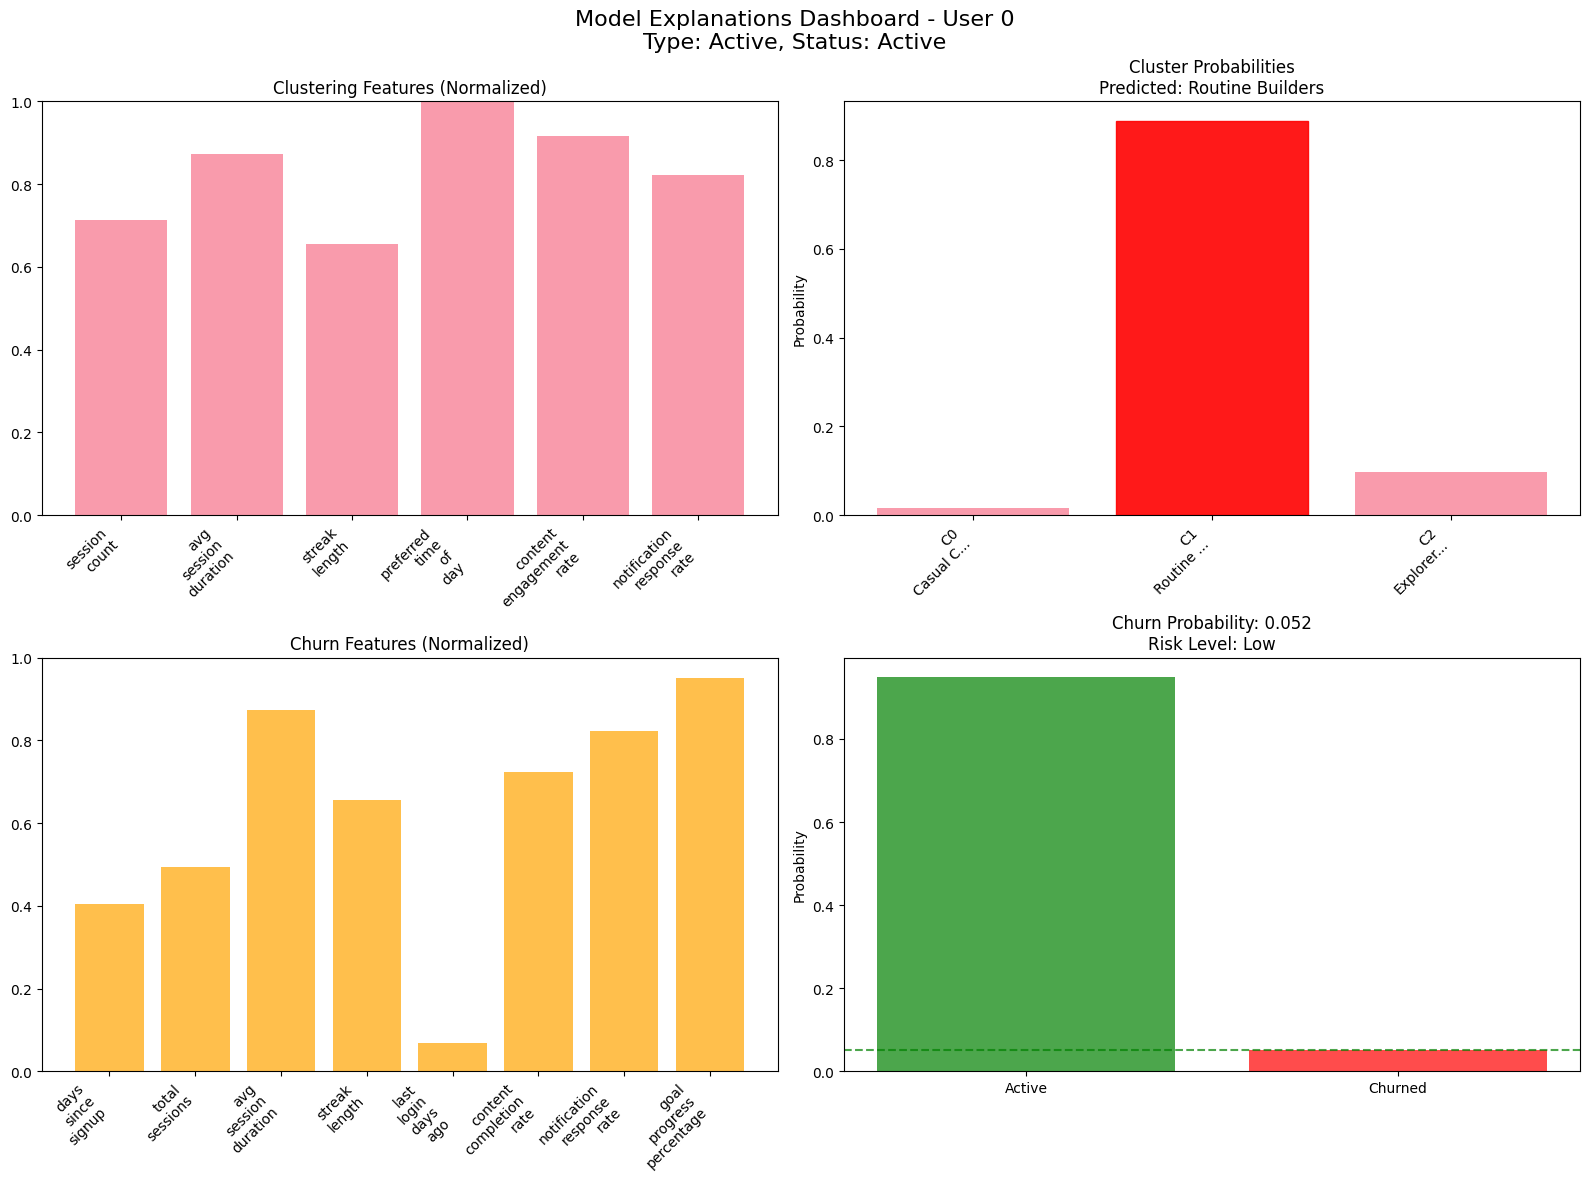


📊 DETAILED EXPLANATION FOR USER 0
User Profile: Active user, Active

🏷️  Clustering Prediction:
   Assigned to: Cluster 1 - Routine Builders
   Confidence: 0.888
   Description: Users who prefer structured, consistent wellness routines with high engagement

🚨 Churn Prediction:
   Churn Probability: 0.052
   Risk Level: Low
   Recommendation: Continue current engagement


In [19]:
# Create comprehensive explanation dashboard
def create_explanation_dashboard(user_index):
    """
    Create a comprehensive dashboard explaining both clustering and churn predictions
    """
    user_info = df.loc[user_index]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Model Explanations Dashboard - User {user_index}\n'
                f'Type: {user_info["user_type"].title()}, '
                f'Status: {"Churned" if user_info["churn"] else "Active"}', 
                fontsize=16)
    
    # 1. User feature values (radar chart style)
    user_clustering_data = X_clustering[user_index]
    user_churn_data = X_churn[user_index]
    
    # Normalize features for radar chart
    clustering_normalized = (user_clustering_data - X_clustering.min(axis=0)) / (X_clustering.max(axis=0) - X_clustering.min(axis=0))
    
    axes[0,0].bar(range(len(clustering_features)), clustering_normalized, alpha=0.7)
    axes[0,0].set_title('Clustering Features (Normalized)')
    axes[0,0].set_xticks(range(len(clustering_features)))
    axes[0,0].set_xticklabels([f.replace('_', '\n') for f in clustering_features], rotation=45, ha='right')
    axes[0,0].set_ylim(0, 1)
    
    # 2. Clustering explanation
    clustering_exp, pred_cluster, cluster_probs = explain_clustering_prediction(user_index, show_plot=False)
    cluster_names = [cluster_info['clusters'][str(i)]['name'] for i in range(len(cluster_info['clusters']))]
    
    axes[0,1].bar(range(len(cluster_probs)), cluster_probs, alpha=0.7)
    axes[0,1].set_title(f'Cluster Probabilities\nPredicted: {cluster_names[pred_cluster]}')
    axes[0,1].set_xticks(range(len(cluster_probs)))
    axes[0,1].set_xticklabels([f'C{i}\n{name[:8]}...' if len(name) > 8 else f'C{i}\n{name}' 
                              for i, name in enumerate(cluster_names)], rotation=45, ha='right')
    axes[0,1].set_ylabel('Probability')
    
    # Highlight predicted cluster
    axes[0,1].patches[pred_cluster].set_color('red')
    axes[0,1].patches[pred_cluster].set_alpha(0.9)
    
    # 3. Churn features
    churn_normalized = (user_churn_data - X_churn.min(axis=0)) / (X_churn.max(axis=0) - X_churn.min(axis=0))
    
    axes[1,0].bar(range(len(churn_features)), churn_normalized, alpha=0.7, color='orange')
    axes[1,0].set_title('Churn Features (Normalized)')
    axes[1,0].set_xticks(range(len(churn_features)))
    axes[1,0].set_xticklabels([f.replace('_', '\n') for f in churn_features], rotation=45, ha='right')
    axes[1,0].set_ylim(0, 1)
    
    # 4. Churn explanation
    churn_exp, churn_prob, churn_probs = explain_churn_prediction(user_index, show_plot=False)
    
    risk_level = "High" if churn_prob >= 0.7 else "Medium" if churn_prob >= 0.4 else "Low"
    risk_color = "red" if risk_level == "High" else "orange" if risk_level == "Medium" else "green"
    
    axes[1,1].bar(['Active', 'Churned'], churn_probs, alpha=0.7, color=['green', 'red'])
    axes[1,1].set_title(f'Churn Probability: {churn_prob:.3f}\nRisk Level: {risk_level}')
    axes[1,1].set_ylabel('Probability')
    
    # Add risk level indicator
    axes[1,1].axhline(y=churn_prob, color=risk_color, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed explanation
    print(f"\n📊 DETAILED EXPLANATION FOR USER {user_index}")
    print("=" * 60)
    print(f"User Profile: {user_info['user_type'].title()} user, {('Churned' if user_info['churn'] else 'Active')}")
    
    print(f"\n🏷️  Clustering Prediction:")
    print(f"   Assigned to: Cluster {pred_cluster} - {cluster_names[pred_cluster]}")
    print(f"   Confidence: {cluster_probs[pred_cluster]:.3f}")
    print(f"   Description: {cluster_info['clusters'][str(pred_cluster)]['description']}")
    
    print(f"\n🚨 Churn Prediction:")
    print(f"   Churn Probability: {churn_prob:.3f}")
    print(f"   Risk Level: {risk_level}")
    print(f"   Recommendation: {'Immediate intervention needed' if risk_level == 'High' else 'Monitor closely' if risk_level == 'Medium' else 'Continue current engagement'}")

# Create dashboard for a sample user
print("🎛️  Creating comprehensive explanation dashboard...")
create_explanation_dashboard(sample_indices[0])

In [20]:
# Interactive explanation function
def interactive_user_explanation(user_id=None):
    """
    Interactive function to explain any user's predictions
    """
    if user_id is None:
        # Show available user types and sample indices
        print("🔍 Available Users for Explanation:")
        print("\nUser Types in Dataset:")
        for user_type in df['user_type'].unique():
            count = len(df[df['user_type'] == user_type])
            churn_rate = df[df['user_type'] == user_type]['churn'].mean()
            print(f"   • {user_type.title()}: {count:,} users (churn rate: {churn_rate:.1%})")
        
        print(f"\n📋 Sample User Indices: {sample_indices[:10]}")
        print("\nTo explain a specific user, call: interactive_user_explanation(user_index)")
        print("Example: interactive_user_explanation(42)")
        return
    
    if user_id not in df.index:
        print(f"❌ User {user_id} not found in dataset!")
        print(f"Available range: 0 to {len(df)-1}")
        return
    
    # Create full explanation for the user
    create_explanation_dashboard(user_id)
    
    # Show specific feature contributions
    print(f"\n🔍 TOP FEATURE CONTRIBUTIONS:")
    
    # Clustering features
    clustering_exp, _, _ = explain_clustering_prediction(user_id, show_plot=False)
    pred_cluster = clustering_explanations.get(user_id, {}).get('predicted_cluster', 0)
    clustering_features_list = clustering_exp.as_list(label=pred_cluster)
    
    print(f"\nClustering (top 3 features):")
    for i, (feature, importance) in enumerate(clustering_features_list[:3], 1):
        direction = "increases" if importance > 0 else "decreases"
        print(f"   {i}. {feature} {direction} cluster probability by {abs(importance):.3f}")
    
    # Churn features
    churn_exp, _, _ = explain_churn_prediction(user_id, show_plot=False)
    churn_features_list = churn_exp.as_list(label=1)
    
    print(f"\nChurn Prediction (top 3 features):")
    for i, (feature, importance) in enumerate(churn_features_list[:3], 1):
        direction = "increases" if importance > 0 else "decreases"
        print(f"   {i}. {feature} {direction} churn probability by {abs(importance):.3f}")

# Show usage instructions
interactive_user_explanation()

🔍 Available Users for Explanation:

User Types in Dataset:
   • Active: 700 users (churn rate: 9.4%)
   • Moderate: 700 users (churn rate: 31.3%)
   • Low_Engagement: 600 users (churn rate: 72.5%)

📋 Sample User Indices: [0, 353, 1860, 1333, 1400, 700]

To explain a specific user, call: interactive_user_explanation(user_index)
Example: interactive_user_explanation(42)


In [21]:
# Generate explanations for different user types
print("👥 EXPLANATIONS BY USER TYPE")
print("=" * 50)

user_type_examples = {}

for user_type in df['user_type'].unique():
    # Find a representative user of this type
    user_subset = df[df['user_type'] == user_type]
    
    # Pick a user close to the median for this type
    median_engagement = user_subset['content_engagement_rate'].median()
    closest_user = user_subset.iloc[(user_subset['content_engagement_rate'] - median_engagement).abs().argsort()[:1]]
    user_idx = closest_user.index[0]
    
    user_type_examples[user_type] = user_idx
    
    print(f"\n🎯 Representative {user_type.title()} User (Index: {user_idx}):")
    print("-" * 40)
    
    # Quick explanation
    clustering_exp, pred_cluster, cluster_probs = explain_clustering_prediction(user_idx, show_plot=False)
    churn_exp, churn_prob, _ = explain_churn_prediction(user_idx, show_plot=False)
    
    cluster_name = cluster_info['clusters'][str(pred_cluster)]['name']
    risk_level = "High" if churn_prob >= 0.7 else "Medium" if churn_prob >= 0.4 else "Low"
    
    print(f"Cluster Assignment: {cluster_name} (confidence: {cluster_probs[pred_cluster]:.3f})")
    print(f"Churn Risk: {risk_level} (probability: {churn_prob:.3f})")
    
    # Top contributing features
    clustering_top = clustering_exp.as_list(label=pred_cluster)[0]
    churn_top = churn_exp.as_list(label=1)[0]
    
    print(f"Key clustering factor: {clustering_top[0]} ({clustering_top[1]:+.3f})")
    print(f"Key churn factor: {churn_top[0]} ({churn_top[1]:+.3f})")

print(f"\n✅ Generated explanations for {len(user_type_examples)} user types")
print("\nTo see detailed explanations for any of these users, use:")
for user_type, user_idx in user_type_examples.items():
    print(f"   interactive_user_explanation({user_idx})  # {user_type} user")

👥 EXPLANATIONS BY USER TYPE

🎯 Representative Active User (Index: 631):
----------------------------------------

🎯 CLUSTERING EXPLANATION - User 631
User Type: active
Predicted Cluster: 1 - Routine Builders
Confidence: 0.751

🎯 CHURN EXPLANATION - User 631
User Type: active
Actual Status: Active
Predicted Status: Active
Churn Probability: 0.206
Risk Level: Low
Cluster Assignment: Routine Builders (confidence: 0.751)
Churn Risk: Low (probability: 0.206)
Key clustering factor: streak_length > 11.00 (+0.193)
Key churn factor: content_completion_rate > 0.77 (-0.083)

🎯 Representative Moderate User (Index: 1025):
----------------------------------------

🎯 CLUSTERING EXPLANATION - User 1025
User Type: moderate
Predicted Cluster: 2 - Explorers
Confidence: 0.733

🎯 CHURN EXPLANATION - User 1025
User Type: moderate
Actual Status: Active
Predicted Status: Active
Churn Probability: 0.266
Risk Level: Low
Cluster Assignment: Explorers (confidence: 0.733)
Churn Risk: Low (probability: 0.266)
Key c

In [22]:
# Summary and insights
print("📋 MODEL EXPLAINABILITY SUMMARY")
print("=" * 50)

print("\n🎯 KEY INSIGHTS FROM LIME EXPLANATIONS:")

print("\n1. 🏷️  Clustering Model:")
print("   • Groups users based on engagement patterns and session behavior")
print("   • Most important features typically include session count and engagement rate")
print("   • Time preferences and notification responses help distinguish user types")

print("\n2. 🚨 Churn Model:")
print("   • Focuses on recency and consistency metrics")
print("   • Days since last login and goal progress are strong predictors")
print("   • Content completion rate indicates user satisfaction")

print("\n3. 🔍 Model Transparency:")
print("   • LIME provides instance-level explanations for individual users")
print("   • Feature contributions can be positive (increase probability) or negative")
print("   • Explanations help validate model behavior and build trust")

print("\n📊 PRACTICAL APPLICATIONS:")
print("\n• 🎯 Personalized Interventions:")
print("     - Target specific features that drive churn for each user")
print("     - Customize content based on cluster characteristics")

print("\n• 📈 Product Insights:")
print("     - Understand which features matter most for different user types")
print("     - Identify opportunities for app improvements")

print("\n• 🔧 Model Debugging:")
print("     - Detect biased or unexpected model behavior")
print("     - Validate model decisions against domain expertise")

print("\n✨ NEXT STEPS:")
print("\n1. Use interactive_user_explanation(user_id) to explore specific users")
print("2. Monitor feature importance patterns over time")
print("3. Integrate explanations into the production application")
print("4. Use insights to improve model features and business logic")

print("\n🎉 Model explainability analysis complete!")
print("Your models are now transparent and interpretable! 🚀")

📋 MODEL EXPLAINABILITY SUMMARY

🎯 KEY INSIGHTS FROM LIME EXPLANATIONS:

1. 🏷️  Clustering Model:
   • Groups users based on engagement patterns and session behavior
   • Most important features typically include session count and engagement rate
   • Time preferences and notification responses help distinguish user types

2. 🚨 Churn Model:
   • Focuses on recency and consistency metrics
   • Days since last login and goal progress are strong predictors
   • Content completion rate indicates user satisfaction

3. 🔍 Model Transparency:
   • LIME provides instance-level explanations for individual users
   • Feature contributions can be positive (increase probability) or negative
   • Explanations help validate model behavior and build trust

📊 PRACTICAL APPLICATIONS:

• 🎯 Personalized Interventions:
     - Target specific features that drive churn for each user
     - Customize content based on cluster characteristics

• 📈 Product Insights:
     - Understand which features matter most fo